In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy import units as u
from astropy import constants as const
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
#import os.path
#import glob

In [2]:
from time import strftime, localtime

In [3]:
from scipy.stats import linregress

In [2]:
import seaborn as sns

In [3]:
colloquiumpath = '/users/brodriguez/Documents/Notebooks/colloquiumfigures/'
databasepath = '/vol/aibn1081/data1/brodriguez/Databases/'
figurepath   = '/vol/aibn1081/data1/brodriguez/Figures/'
califaoutpath = '/vol/aibn1081/data1/brodriguez/CALIFA/'
acaoutpath    = '/vol/aibn1081/data1/brodriguez/ACA/'
califainpath  = '/vol/alcina/data1/shared/EDGE/PIPE3DS_v2.3/'
acainpath     = '/vol/alcina/data1/shared/EDGE/aca_edge_natv/cubes/'

## Creating auxiliary D4000 - sSFR database from CALIFA sources

In [ ]:
califapattern = os.path.join(califainpath,"*.Pipe3D.cube.fits.gz")
acapattern = os.path.join(acainpath,"*_7m_co21_pbcor.fits")
print("CALIFA input pattern:",califapattern)
print("ACA input pattern:",acapattern)
califafilepaths = sorted(glob.glob(califapattern))
acafilepaths = sorted(glob.glob(acapattern))

In [ ]:
califa_sources = [filename.replace('.Pipe3D.cube.fits.gz','').replace(califainpath,'') for filename in califafilepaths]
aca_sources = [filename.replace('_7m_co21_pbcor.fits','').replace(acainpath,'') for filename in acafilepaths]

### From all CALIFA sources

In [ ]:
califa_table = pd.read_csv('/users/brodriguez/Documents/get_proc_elines_CALIFA_2022.csv',sep=',',skiprows=587,index_col=0,
                    usecols=['name','z_stars','log_Mass','log_SFR_SF','Re_arc','Re_kpc','Inclination','P.A.'])

In [ ]:
califa_sources = califa_sources[np.isin(califa_sources,califa_table.index)]

In [ ]:
califa_table.loc[califa_sources,:]

In [ ]:
D4000_Data = []
t1 = time()
for source in califa_sources[:]:
    print('\nInitializing source',source)
    #t1 = time()
    try:
        hdu_list = fits.open(califainpath+source+'.Pipe3D.cube.fits.gz')
    except:
        print('Could not open fits file for source',source)
        continue
    califa_hdr = WCS(hdu_list[0].header).celestial.to_header()
    #pix_scale_califa = califa_hdr['PC2_2']*3600 # pixel size in arcsec
    
    z = califa_table.loc[source,'z_stars']
    inc = califa_table.loc[source,'Inclination']
    cos = np.cos(np.deg2rad(inc))
    PA = califa_table.loc[source,'P.A.']-90 # Position angle in degrees
    Re = califa_table.loc[source,'Re_arc'] # Effective radius in arcsec
    D_lum = cosmo.luminosity_distance(z)
    D_ang = cosmo.angular_diameter_distance(z)
    pix_area_califa = ((np.deg2rad(califa_hdr['PC2_2'])*D_ang)**2).to(u.kpc**2)
    
    # fluxes (and errors) in 10^-16 erg s^-1 cm^-2
    F_NII = hdu_list[5].data[46]
    F_OIII = hdu_list[5].data[26]
    F_Ha = hdu_list[5].data[45]
    F_Hb = hdu_list[5].data[28]
    eF_NII = hdu_list[5].data[262]
    eF_OIII = hdu_list[5].data[242]
    eF_Ha = hdu_list[5].data[261]
    eF_Hb = hdu_list[5].data[244]
    # Equivalent Width in Angstrom
    EW_Ha = -hdu_list[5].data[207] # emission line EW defined as negative
    eEW_Ha = hdu_list[5].data[423]
    # obtaining stellar mass by correcting with dezonification zone
    Mstar = np.power(10,hdu_list[1].data[19])*hdu_list[1].data[2]
    #eMstar = np.power(10,hdu_list[1].data[20])*hdu_list[1].data[2]
    
    D4000 = hdu_list[3].data[0]
    eD4000 = hdu_list[3].data[35]
    Age = np.power(10,hdu_list[1].data[5])*hdu_list[1].data[2]
    
    # 2D masks
    gaia = hdu_list[7].data # bright star mask
    region = hdu_list[8].data # valid region mask
    hdu_list.close()
    region = region&np.where(gaia!=0,0,1)&np.where(Mstar>0,1,0)
    for frame in [F_Ha,F_Hb,F_OIII,F_NII,EW_Ha,Mstar,eF_Ha,eF_Hb,eF_OIII,eF_NII,eEW_Ha,D4000,eD4000,Age]:#,eMstar
        frame[region<1] = np.nan
        
    # creating mask according to Ha_EW>6A and Ha_EW S/N>1
    Ha_mask = (EW_Ha/eEW_Ha>1)&(EW_Ha>6)
    
    # creating a mask for high S/N in all emission lines
    High_SN = (F_Ha>3*eF_Ha)&(F_Hb>3*eF_Hb)&(F_OIII>3*eF_OIII)&(F_NII>3*eF_NII)
    
    SF = (np.log10(F_OIII/F_Hb)<(0.61/(np.log10(F_NII/F_Ha)-0.05) + 1.3))&(np.log10(F_NII/F_Ha)<0.05)
    quiescent = (Age>3*10**9)&(F_Ha<eF_Ha)&((F_Hb<3*eF_Hb)|(F_OIII<3*eF_OIII)|(F_NII<3*eF_NII))
    
    Ha_to_Hb = np.where(F_Ha/F_Hb>2.86,F_Ha/F_Hb,2.86) # imposing minimum ratio of 2.86
    #Ha_to_Hb = np.where(F_Ha>0,Ha_to_Hb,np.nan)
    # from Villanueva et al. 2023
    A_Ha = 5.86*np.log10(Ha_to_Hb/2.86)
    #A_Ha_median = np.nanmedian(A_Ha[(A_Ha>0)&(F_Hb>eF_Hb)])
    #A_Ha = np.where(~(F_Hb>eF_Hb)&(F_Ha>0),A_Ha_median,A_Ha)
    #SFR = 1.6*7.9*(10**-(42+16))*F_Ha*np.power(10,A_Ha/2.5)*4*np.pi*(D_lum**2).to(u.cm**2).value
    SFR =      7.9*(10**-(42+16))*F_Ha*np.power(10,A_Ha/2.5)*4*np.pi*(D_lum**2).to(u.cm**2).value
    
    S_Mstar = Mstar*cos/pix_area_califa.value # stellar mass surface density in M_sun kpc^-2
    S_SFR   = SFR  *cos/pix_area_califa.value
    flat_region = ((S_Mstar>0)&(D4000>5*eD4000)).flatten()

    Partial_Database = pd.DataFrame({'Source':np.broadcast_to(source,S_Mstar.flatten().shape)[flat_region],
                                     'Inclination':np.broadcast_to(inc,S_Mstar.flatten().shape)[flat_region],
                                     'S_Mstar':S_Mstar.flatten()[flat_region],
                                     'S_SFR_Ha':S_SFR.flatten()[flat_region],
                                     'Ha_mask':Ha_mask.flatten()[flat_region],
                                     'High_SN':High_SN.flatten()[flat_region],
                                     'quiescent':quiescent.flatten()[flat_region],
                                     'SF':SF.flatten()[flat_region],
                                     #'Ha':F_Ha.flatten()[flat_region],
                                     #'eHa':eF_Ha.flatten()[flat_region],
                                     #'Hb':F_Hb.flatten()[flat_region],
                                     #'eHb':eF_Hb.flatten()[flat_region],
                                     #'OIII':F_OIII.flatten()[flat_region],
                                     #'eOIII':eF_OIII.flatten()[flat_region],
                                     #'NII':F_NII.flatten()[flat_region],
                                     #'eNII':eF_NII.flatten()[flat_region],
                                     'D4000':D4000.flatten()[flat_region]})
                                     #'eD4000':eD4000.flatten()[flat_region],
                                     #'Age':Age.flatten()[flat_region]})
    D4000_Data.append(Partial_Database)
t2 = time()
print('Time in seconds:',t2-t1)

In [ ]:
D4000_Data = pd.concat(D4000_Data,ignore_index=True)
D4000_Data.info()

In [ ]:
D4000_Data.to_csv('/users/brodriguez/Documents/D4000_database_'+strftime("%Y-%m-%d",localtime())+'.csv',index=False)

### From ACA sources only

In [ ]:
D4000_Data = []
for source in sources[:]:
    print('\nInitializing source',source)
    z = aca_table.loc[source,'z_stars']
    inc = aca_table.loc[source,'inclination_califa']
    cos = np.cos(np.deg2rad(inc))
    PA = aca_table.loc[source,'PA_califa']-90 # Position angle in degrees
    Re = aca_table.loc[source,'Re_arc_califa'] # Effective radius in arcsec
    D_lum = cosmo.luminosity_distance(z)
    D_ang = cosmo.angular_diameter_distance(z)
    #Re = np.deg2rad(Re/3600)*D_ang.to(u.kpc).value # Effective radius in kpc
    #hs = Re/(1.68*7.3) # disc scale height in kpc
    
    Mstar, califa_hdr = get_data(califaoutpath+source+'_Mstar.fits',header=True)
    pix_scale_califa = califa_hdr['PC2_2']*3600 # pixel size in arcsec
    pix_area_califa = ((np.deg2rad(califa_hdr['PC2_2'])*D_ang)**2).to(u.kpc**2)
    
    Ha_mask = get_data(califaoutpath+source+'_Ha_mask.fits')
    F_NII = get_data(califaoutpath+source+'_F_NII.fits')
    F_OIII = get_data(califaoutpath+source+'_F_OIII.fits')
    F_Ha = get_data(califaoutpath+source+'_F_Ha.fits')
    F_Hb = get_data(califaoutpath+source+'_F_Hb.fits')
    eF_NII = get_data(califaoutpath+source+'_eF_NII.fits')
    eF_OIII = get_data(califaoutpath+source+'_eF_OIII.fits')
    eF_Ha = get_data(califaoutpath+source+'_eF_Ha.fits')
    eF_Hb = get_data(califaoutpath+source+'_eF_Hb.fits')
    D4000 = get_data(califaoutpath+source+'_D4000.fits')
    eD4000 = get_data(califaoutpath+source+'_eD4000.fits')
    Age = get_data(califaoutpath+source+'_LumAge.fits')

    Ha_to_Hb = np.where(F_Ha/F_Hb>2.86,F_Ha/F_Hb,2.86) # imposing minimum ratio of 2.86
    Ha_to_Hb = np.where(F_Ha>0,Ha_to_Hb,np.nan)
    # from Villanueva et al. 2023
    A_Ha = 5.86*np.log10(Ha_to_Hb/2.86)
    A_Ha_median = np.nanmedian(A_Ha[(A_Ha>0)&(F_Hb>eF_Hb)])
    A_Ha = np.where(~(F_Hb>eF_Hb)&(F_Ha>0),A_Ha_median,A_Ha)
    #SFR = 1.6*7.9*(10**-(42+16))*F_Ha*np.power(10,A_Ha/2.5)*4*np.pi*(D_lum**2).to(u.cm**2).value
    SFR = 7.9*(10**-(42+16))*F_Ha*np.power(10,A_Ha/2.5)*4*np.pi*(D_lum**2).to(u.cm**2).value
    
    S_Mstar = Mstar*cos/pix_area_califa.value # stellar mass surface density in M_sun kpc^-2
    S_SFR   = SFR  *cos/pix_area_califa.value
    flat_region = Mstar.flatten()>0

    Partial_Database = pd.DataFrame({'Source':np.broadcast_to(source,S_Mstar.flatten().shape)[flat_region],
                                     'Inclination':np.broadcast_to(inc,S_Mstar.flatten().shape)[flat_region],
                                     'S_Mstar':S_Mstar.flatten()[flat_region],
                                     'S_SFR_Ha':S_SFR.flatten()[flat_region],
                                     'Ha_mask':Ha_mask.flatten()[flat_region],
                                     'Ha':F_Ha.flatten()[flat_region],
                                     'eHa':eF_Ha.flatten()[flat_region],
                                     'Hb':F_Hb.flatten()[flat_region],
                                     'eHb':eF_Hb.flatten()[flat_region],
                                     'OIII':F_OIII.flatten()[flat_region],
                                     'eOIII':eF_OIII.flatten()[flat_region],
                                     'NII':F_NII.flatten()[flat_region],
                                     'eNII':eF_NII.flatten()[flat_region],
                                     'D4000':D4000.flatten()[flat_region],
                                     'eD4000':eD4000.flatten()[flat_region],
                                     'Age':Age.flatten()[flat_region]})
    D4000_Data.append(Partial_Database)

In [ ]:
D4000_Data = pd.concat(D4000_Data,ignore_index=True)
D4000_Data.info()

In [ ]:
D4000_Data.to_csv('/users/brodriguez/Documents/D4000_database_'+strftime("%Y-%m-%d",localtime())+'.csv',index=False)

## Computing sSFR-D4000 relation

In [4]:
from astropy.cosmology import LambdaCDM#, FlatLambdaCDM
cosmo = LambdaCDM(H0=69.7,Om0=0.3,Ode0=0.7)

In [7]:
def create_bins(number,bin_width=1):
    q = np.floor(number/bin_width)
    return q*bin_width

In [5]:
def create_bins(number,bin_width=1,init_value=0.):
    q = np.floor((number-init_value)/bin_width)
    return q*bin_width+init_value

In [6]:
Database = pd.read_csv(databasepath+'D4000_database_2024-05-08.csv')
Database['Source'] = Database['Source'].astype("category")
Database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681394 entries, 0 to 681393
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   Source       681394 non-null  category
 1   Inclination  681394 non-null  float64 
 2   S_Mstar      681394 non-null  float64 
 3   S_SFR_Ha     599900 non-null  float64 
 4   Ha_mask      681394 non-null  int64   
 5   Ha           681394 non-null  float64 
 6   eHa          681394 non-null  float64 
 7   Hb           681394 non-null  float64 
 8   eHb          681394 non-null  float64 
 9   OIII         681394 non-null  float64 
 10  eOIII        681394 non-null  float64 
 11  NII          681394 non-null  float64 
 12  eNII         681394 non-null  float64 
 13  D4000        681394 non-null  float64 
 14  eD4000       681394 non-null  float64 
 15  Age          681394 non-null  float64 
dtypes: category(1), float64(14), int64(1)
memory usage: 78.6 MB


In [7]:
Database = Database[Database['Inclination']<70]

In [9]:
Database.info()

<class 'pandas.core.frame.DataFrame'>
Index: 526447 entries, 0 to 672859
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   Source       526447 non-null  category
 1   Inclination  526447 non-null  float64 
 2   S_Mstar      526447 non-null  float64 
 3   S_SFR_Ha     462561 non-null  float64 
 4   Ha_mask      526447 non-null  int64   
 5   Ha           526447 non-null  float64 
 6   eHa          526447 non-null  float64 
 7   Hb           526447 non-null  float64 
 8   eHb          526447 non-null  float64 
 9   OIII         526447 non-null  float64 
 10  eOIII        526447 non-null  float64 
 11  NII          526447 non-null  float64 
 12  eNII         526447 non-null  float64 
 13  D4000        526447 non-null  float64 
 14  eD4000       526447 non-null  float64 
 15  Age          526447 non-null  float64 
dtypes: category(1), float64(14), int64(1)
memory usage: 64.8 MB


In [8]:
#Database['S_SFR_Ha'] = Database['S_SFR_Ha']/1.6
Database['sSFR'] = Database['S_SFR_Ha']/Database['S_Mstar']
Database['log_sSFR'] = np.log10(Database['sSFR'])
Database['OIII_Hb'] = np.log10(Database['OIII']/Database['Hb'])
Database['NII_Ha']  = np.log10(Database['NII']/Database['Ha'])

/users/brodriguez/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/users/brodriguez/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [262]:
len(Database[Database['Inclination']<70])

526447

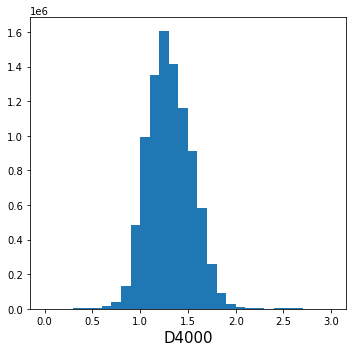

In [10]:
fig, ax = plt.subplots(figsize=(5,5))#,sharex='col',sharey='row')
ax.hist(Database['D4000'],bins=np.linspace(0,3.,31))
ax.set_xlabel(r'D4000',size=15)
#ax.set_xlim(0.8,2.2)
fig.tight_layout()
#ax.legend(loc='best')
plt.show()

In [16]:
from matplotlib.patches import Ellipse

def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

-6.913342767833663
0.6392737930088875


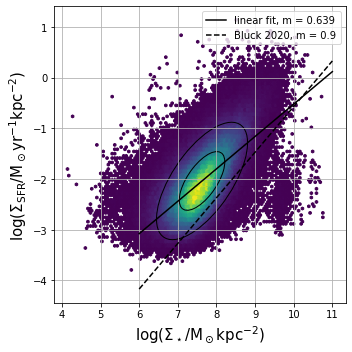

In [29]:
mask = (Database['High_SN']==True)&(Database['SF']==True)
x = np.log10(Database.loc[mask,'S_Mstar'])#[5,7,11,15,16,17,18]
y = np.log10(Database.loc[mask,'S_SFR_Ha'])#[25, 18, 17, 9, 8, 5, 8]
cov = np.cov(x, y)
vals, vecs = eigsorted(cov)
theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

SFMS = linregress(np.log10(Database.loc[mask,'S_Mstar']),np.log10(Database.loc[mask,'S_SFR_Ha']))
print(SFMS.intercept)
print(SFMS.slope)
fig, ax = plt.subplots(figsize=(5,5))#,sharex='col',sharey='row')
im = ax.hexbin(np.log10(Database.loc[mask,'S_Mstar']),np.log10(Database.loc[mask,'S_SFR_Ha']),mincnt=1)
ax.plot([6,11],[6*SFMS.slope+SFMS.intercept,11*SFMS.slope+SFMS.intercept],c='k',label=f'linear fit, m = {SFMS.slope:.3}')
ax.plot([6,11],[6*0.9-9.57,11*0.9-9.57],c='k',ls='--',label='Bluck 2020, m = 0.9')
for nstd in range(1,3):
    w, h = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)), width=w, height=h, angle=theta, color='black')
    ell.set_facecolor('none')
    ax.add_artist(ell)
ax.set_xlabel(r'log($\Sigma_\star$/M$_\odot$kpc$^{-2}$)',size=15)
ax.set_ylabel(r'log($\Sigma_\mathrm{SFR}$/M$_\odot$yr$^{-1}$kpc$^{-2}$)',size=15)
ax.grid(True)
fig.tight_layout()
ax.legend(loc='best')
plt.show()

-8.040800930020586
0.7381898582175024


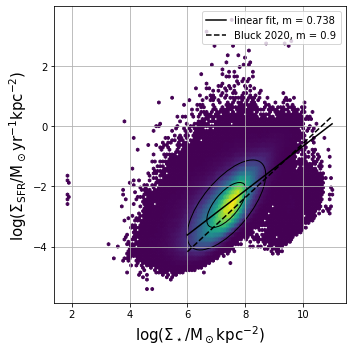

In [28]:
mask = (Database['Ha_mask']==True)&(Database['SF']==True)
x = np.log10(Database.loc[mask,'S_Mstar'])#[5,7,11,15,16,17,18]
y = np.log10(Database.loc[mask,'S_SFR_Ha'])#[25, 18, 17, 9, 8, 5, 8]
cov = np.cov(x, y)
vals, vecs = eigsorted(cov)
theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

SFMS = linregress(np.log10(Database.loc[mask,'S_Mstar']),np.log10(Database.loc[mask,'S_SFR_Ha']))
print(SFMS.intercept)
print(SFMS.slope)
fig, ax = plt.subplots(figsize=(5,5))#,sharex='col',sharey='row')
im = ax.hexbin(np.log10(Database.loc[mask,'S_Mstar']),np.log10(Database.loc[mask,'S_SFR_Ha']),mincnt=1)
ax.plot([6,11],[6*SFMS.slope+SFMS.intercept,11*SFMS.slope+SFMS.intercept],c='k',label=f'linear fit, m = {SFMS.slope:.3}')
ax.plot([6,11],[6*0.9-9.57,11*0.9-9.57],c='k',ls='--',label='Bluck 2020, m = 0.9')
for nstd in range(1,3):
    w, h = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)), width=w, height=h, angle=theta, color='black')
    ell.set_facecolor('none')
    ax.add_artist(ell)
ax.set_xlabel(r'log($\Sigma_\star$/M$_\odot$kpc$^{-2}$)',size=15)
ax.set_ylabel(r'log($\Sigma_\mathrm{SFR}$/M$_\odot$yr$^{-1}$kpc$^{-2}$)',size=15)
ax.grid(True)
fig.tight_layout()
ax.legend(loc='best')
plt.show()

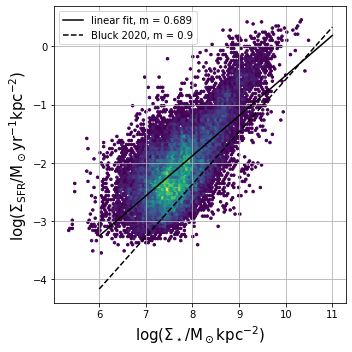

In [27]:
#SFMS = linregress(np.log10(Database_SF['S_Mstar']),np.log10(Database_SF['S_SFR_Ha']))
#print(SFMS.intercept)
#print(SFMS.slope)
fig, ax = plt.subplots(figsize=(5,5))#,sharex='col',sharey='row')
im = ax.hexbin(np.log10(Database_SF['S_Mstar']),np.log10(Database_SF['S_SFR_Ha']),mincnt=1)
ax.plot([6,11],[6*SFMS.slope+SFMS.intercept,11*SFMS.slope+SFMS.intercept],c='k',label=f'linear fit, m = {SFMS.slope:.3}')
ax.plot([6,11],[6*0.9-9.57,11*0.9-9.57],c='k',ls='--',label='Bluck 2020, m = 0.9')
ax.set_xlabel(r'log($\Sigma_\star$/M$_\odot$kpc$^{-2}$)',size=15)
ax.set_ylabel(r'log($\Sigma_\mathrm{SFR}$/M$_\odot$yr$^{-1}$kpc$^{-2}$)',size=15)
ax.grid(True)
fig.tight_layout()
ax.legend(loc='best')
plt.show()

-8.403306000979612
0.7673186020491958


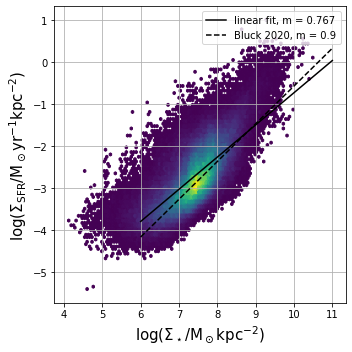

In [29]:
mask = np.isfinite(Database_SF['S_Mstar'])&np.isfinite(Database_SF['S_SFR_Ha'])
SFMS = linregress(np.log10(Database_SF.loc[mask,'S_Mstar']),np.log10(Database_SF.loc[mask,'S_SFR_Ha']))
print(SFMS.intercept)
print(SFMS.slope)
fig, ax = plt.subplots(figsize=(5,5))#,sharex='col',sharey='row')
im = ax.hexbin(np.log10(Database_SF['S_Mstar']),np.log10(Database_SF['S_SFR_Ha']),mincnt=1)
ax.plot([6,11],[6*SFMS.slope+SFMS.intercept,11*SFMS.slope+SFMS.intercept],c='k',label=f'linear fit, m = {SFMS.slope:.3}')
ax.plot([6,11],[6*0.9-9.57,11*0.9-9.57],c='k',ls='--',label='Bluck 2020, m = 0.9')
ax.set_xlabel(r'log($\Sigma_\star$/M$_\odot$kpc$^{-2}$)',size=15)
ax.set_ylabel(r'log($\Sigma_\mathrm{SFR}$/M$_\odot$yr$^{-1}$kpc$^{-2}$)',size=15)
ax.grid(True)
fig.tight_layout()
ax.legend(loc='best')
plt.show()

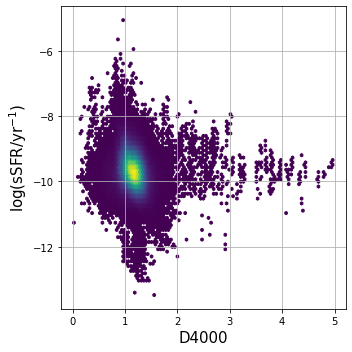

In [32]:
mask = (Database['High_SN']==True)&(Database['SF']==True)&(Database['D4000']<5.)
fig, ax = plt.subplots(figsize=(5,5))#,sharex='col',sharey='row')
im = ax.hexbin(Database.loc[mask,'D4000'],np.log10(Database.loc[mask,'sSFR']),mincnt=1)
ax.set_xlabel(r'D4000',size=15)
ax.set_ylabel(r'log(sSFR/yr$^{-1}$)',size=15)
ax.grid(True)
fig.tight_layout()
#ax.legend(loc='best')
plt.show()

In [8]:
Database['sSFR_new'] = Database['sSFR']
Database.loc[(Database['quiescent']==True),'sSFR_new'] = 10**-12
maskSF = (Database['High_SN']==True)&(Database['SF']==True)&(Database['D4000']<2.)&(Database['D4000']>0.8)
maskQ  = (Database['quiescent']==True)&(Database['SF']==True)&(Database['D4000']<2.)&(Database['D4000']>0.8)
concat = pd.concat([Database.loc[maskSF,['sSFR_new','D4000']],Database.loc[maskQ,['sSFR_new','D4000']]],ignore_index=True)

In [9]:
D4_binwidth = 0.03
concat_byD4 = concat.groupby(create_bins(concat['D4000'],D4_binwidth))
concat_byD4_median = concat_byD4.median()#[['log_S_Mstar','log_S_SFR','R_21','Z_O3N2','Z_N2','alphaCO_O3N2','alphaCO_N2','log_S_mol_O3N2','CO_vdisp','star_vdisp','log_f_CO','log_sSFR','log_SFE','log_P_h']].median()
concat_byD4_std    = concat_byD4.std()

/users/brodriguez/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


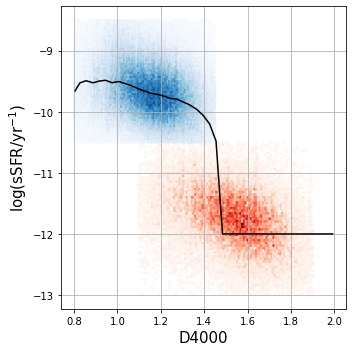

In [12]:
fig, ax = plt.subplots(figsize=(5,5))#,sharex='col',sharey='row')
im = ax.hexbin(Database.loc[maskQ,'D4000'],np.log10(Database.loc[maskQ,'sSFR']),mincnt=1,extent=(1.1,1.9,-13,-10.5),cmap='Reds')
im = ax.hexbin(Database.loc[maskSF,'D4000'],np.log10(Database.loc[maskSF,'sSFR']),mincnt=1,extent=(0.8,1.45,-10.5,-8.5),cmap='Blues')
ax.plot(concat_byD4_median['D4000'].to_numpy(),np.log10(concat_byD4_median['sSFR_new'].to_numpy()),c='k')
#ax.plot(concat_byD4_median['D4000'].to_numpy(),np.log10((concat_byD4_median['sSFR_new']+concat_byD4_std['sSFR_new']).to_numpy()),c='k',ls=':')
#ax.plot(concat_byD4_median['D4000'].to_numpy(),np.log10((concat_byD4_median['sSFR_new']-concat_byD4_std['sSFR_new']).to_numpy()),c='k',ls=':')
ax.set_xlabel(r'D4000',size=15)
ax.set_ylabel(r'log(sSFR/yr$^{-1}$)',size=15)
#ax.set_xlim(0.8,2.2)
ax.grid(True)
fig.tight_layout()
#ax.legend(loc='best')
plt.show()

In [11]:
concat_byD4_median.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41 entries, 0.78 to 1.98
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sSFR_new  41 non-null     float64
 1   D4000     41 non-null     float64
dtypes: float64(2)
memory usage: 984.0 bytes


In [13]:
concat_byD4_median

,sSFR_new,D4000
D4000,,
0.78,2.194319e-10,0.805062
0.81,2.962318e-10,0.826788
0.84,3.223728e-10,0.855733
0.87,2.981316e-10,0.888068
0.90,3.176851e-10,0.915297
0.93,3.278539e-10,0.945926
0.96,2.989649e-10,0.975778
0.99,3.131174e-10,1.005715
1.02,2.909111e-10,1.034774


In [43]:
concat_byD4_median.to_csv('/users/brodriguez/Documents/D4000_sSFR_'+strftime("%Y-%m-%d",localtime())+'.csv')

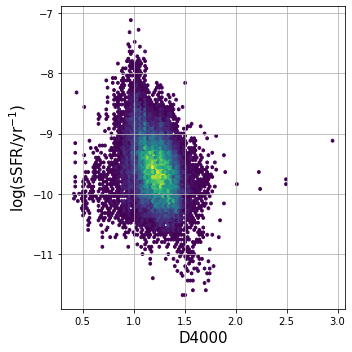

In [38]:
fig, ax = plt.subplots(figsize=(5,5))#,sharex='col',sharey='row')
im = ax.hexbin(Database_SF['D4000'],np.log10(Database_SF['sSFR']),mincnt=1)
ax.set_xlabel(r'D4000',size=15)
ax.set_ylabel(r'log(sSFR/yr$^{-1}$)',size=15)
ax.grid(True)
fig.tight_layout()
#ax.legend(loc='best')
plt.show()

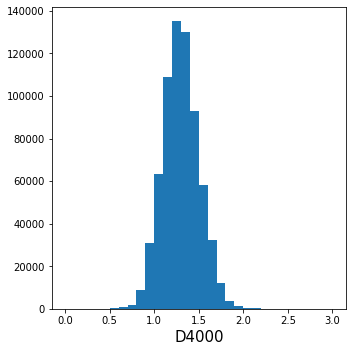

In [8]:
fig, ax = plt.subplots(figsize=(5,5))#,sharex='col',sharey='row')
ax.hist(Database['D4000'],bins=np.linspace(0,3.,31))
ax.set_xlabel(r'D4000',size=15)
#ax.set_xlim(0.8,2.2)
fig.tight_layout()
#ax.legend(loc='best')
plt.show()

309


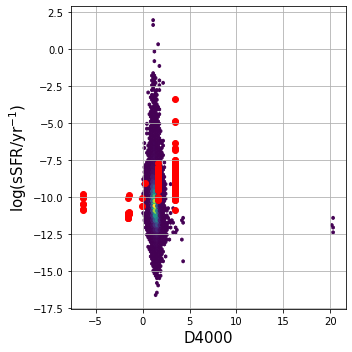

In [99]:
fig, ax = plt.subplots(figsize=(5,5))#,sharex='col',sharey='row')
im = ax.hexbin(Database['D4000'],np.log10(Database['sSFR']),mincnt=1)
data = Database[Database['D4000']/Database['eD4000']<5]
ax.scatter(data['D4000'],np.log10(data['sSFR']),c='r')
ax.set_xlabel(r'D4000',size=15)
ax.set_ylabel(r'log(sSFR/yr$^{-1}$)',size=15)
ax.grid(True)
fig.tight_layout()
#ax.legend(loc='best')
print(np.count_nonzero(Database['D4000']/Database['eD4000']<5))
plt.show()

In [11]:
print(len(Database))

526447


In [9]:
Database = Database[Database['D4000']/Database['eD4000']>5]

In [13]:
print(len(Database))

526444


In [15]:
xNII = [np.linspace(-1.65,0.21,100), np.linspace(-1.65,-0.2,100)]#np.linspace(-0.19935,0.25+0.5,10)]
#yNII = [0.61/(xNII[0]-0.47) + 1.19, 1.01*xNII[1]+0.48]
yNII = [0.61/(xNII[0]-0.47) + 1.19, 0.61/(xNII[1]-0.05) + 1.3]


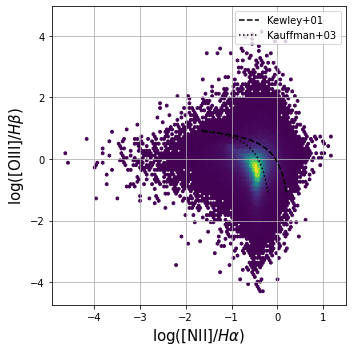

In [19]:
#High_SN = '(Ha>3*eHa)&(Hb>3*eHb)&(OIII>3*eOIII)&(NII>3*eNII)'
#data = Database.query(High_SN)
fig, ax = plt.subplots(figsize=(5,5))#,sharex='col',sharey='row')
im = ax.hexbin(Database.loc[Database['Ha_mask']==1,'NII_Ha'],Database.loc[Database['Ha_mask']==1,'OIII_Hb'],mincnt=1)
ax.plot(xNII[0],yNII[0],c='k',ls='--',label='Kewley+01')
ax.plot(xNII[1],yNII[1],c='k',ls=':',label='Kauffman+03')
ax.set_xlabel(r'log([NII]/$H\alpha$)',size=15)
ax.set_ylabel(r'log([OIII]/$H\beta$)',size=15)
ax.grid(True)
fig.tight_layout()
ax.legend(loc='best')
plt.show()

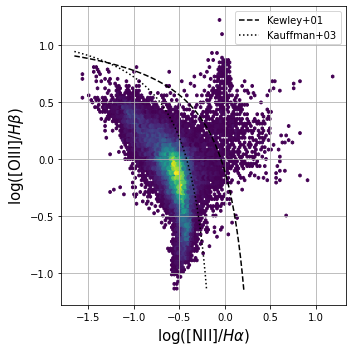

In [28]:
High_SN = '(Ha>3*eHa)&(Hb>3*eHb)&(OIII>3*eOIII)&(NII>3*eNII)'
data = Database.query(High_SN)
fig, ax = plt.subplots(figsize=(5,5))#,sharex='col',sharey='row')
im = ax.hexbin(data['NII_Ha'],data['OIII_Hb'],mincnt=1)
ax.plot(xNII[0],yNII[0],c='k',ls='--',label='Kewley+01')
ax.plot(xNII[1],yNII[1],c='k',ls=':',label='Kauffman+03')
ax.set_xlabel(r'log([NII]/$H\alpha$)',size=15)
ax.set_ylabel(r'log([OIII]/$H\beta$)',size=15)
ax.grid(True)
fig.tight_layout()
ax.legend(loc='best')
plt.show()

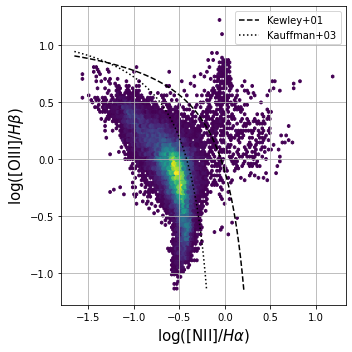

In [11]:
High_SN = '(Ha>3*eHa)&(Hb>3*eHb)&(OIII>3*eOIII)&(NII>3*eNII)'
data = Database.query(High_SN)
fig, ax = plt.subplots(figsize=(5,5))#,sharex='col',sharey='row')
im = ax.hexbin(data.loc[data['Ha_mask']==1,'NII_Ha'],data.loc[data['Ha_mask']==1,'OIII_Hb'],mincnt=1)
ax.plot(xNII[0],yNII[0],c='k',ls='--',label='Kewley+01')
ax.plot(xNII[1],yNII[1],c='k',ls=':',label='Kauffman+03')
ax.set_xlabel(r'log([NII]/$H\alpha$)',size=15)
ax.set_ylabel(r'log([OIII]/$H\beta$)',size=15)
ax.grid(True)
fig.tight_layout()
ax.legend(loc='best')
plt.show()

In [16]:
#SF = '(OIII_Hb<(0.61/(NII_Ha-0.05) + 1.3))&(NII_Ha<0.05)'
#Database_SF = Database.query(High_SN+'&'+SF).copy()

yNII = [0.61/(xNII[0]-0.47) + 1.19, 0.61/(xNII[1]-0.05) + 1.3]

In [11]:
#SF = '(OIII_Hb<(0.61/(NII_Ha-0.05) + 1.3))&(NII_Ha<0.05)&(Ha_mask==1)'
SF = '(OIII_Hb<(0.61/(NII_Ha-0.47) + 1.19))&(NII_Ha<0.47)&(Ha_mask==1)'
Database_SF = Database.query(SF).copy()

In [12]:
len(Database_SF)

143677

In [27]:
Database_SF = Database_SF[np.isfinite(Database_SF['S_SFR_Ha'])]

In [20]:
len(Database_SF)

143616

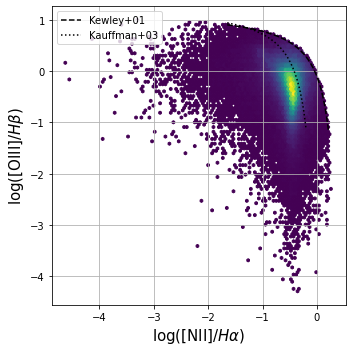

In [19]:
#High_SN = '(Ha>3*eHa)&(Hb>3*eHb)&(OIII>3*eOIII)&(NII>3*eNII)'
#data = Database.query(High_SN)
fig, ax = plt.subplots(figsize=(5,5))#,sharex='col',sharey='row')
im = ax.hexbin(Database_SF['NII_Ha'],Database_SF['OIII_Hb'],mincnt=1)
ax.plot(xNII[0],yNII[0],c='k',ls='--',label='Kewley+01')
ax.plot(xNII[1],yNII[1],c='k',ls=':',label='Kauffman+03')
ax.set_xlabel(r'log([NII]/$H\alpha$)',size=15)
ax.set_ylabel(r'log([OIII]/$H\beta$)',size=15)
ax.grid(True)
fig.tight_layout()
ax.legend(loc='best')
plt.show()

In [13]:
quiescent = '(Age>3*10**9)&(Ha<eHa)&(Ha_mask!=1)&~((Hb>3*eHb)&(OIII>3*eOIII)&(NII>3*eNII))'
Database_Q = Database.query(quiescent).copy()

In [14]:
Database_SF['log_sSFR'] = np.log10(Database_SF['sSFR'])
Database_Q['log_sSFR']  = np.log10(Database_Q['sSFR'])

In [42]:
#Database_SF['sSFR_D4'] = Database_SF['sSFR']
#Database_Q['sSFR_D4'] = 10**-12
Database_SF['log_sSFR_D4'] = np.log10(Database_SF['sSFR_D4'])
Database_Q['log_sSFR_D4']  = np.log10(Database_Q['sSFR_D4'])

In [70]:
concat = pd.concat([Database_SF[['D4000','sSFR_D4','log_sSFR_D4']],Database_Q[['D4000','sSFR_D4','log_sSFR_D4']]],ignore_index=True)

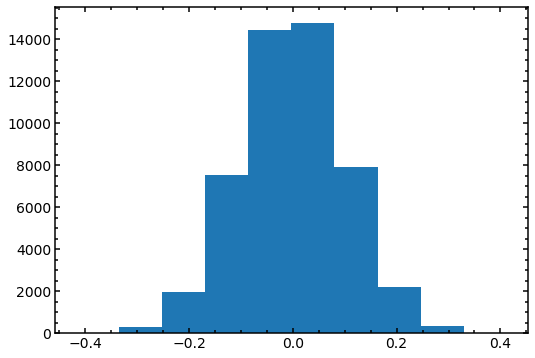

In [22]:
rng = np.random.default_rng()
arr = rng.standard_normal(len(Database_Q))*0.1
plt.hist(arr)
plt.show()
Database_Q['sSFR_D4']*=np.power(10,arr)

In [28]:
concat = pd.concat([Database_SF[['D4000','sSFR_D4']],Database_Q[['D4000','sSFR_D4']]],ignore_index=True)

In [29]:
print(len(Database_SF),len(Database_Q),len(concat))

143616 49534 193150


In [27]:
concat

,D4000,sSFR_D4
0,1.209873,6.064348e-11
1,1.209873,5.050014e-11
2,1.214488,1.179179e-10
3,1.209873,6.713729e-11
4,1.191644,6.883580e-11
...,...,...
193145,1.422133,8.511899e-13
193146,1.629283,8.089938e-13
193147,1.629283,9.954714e-13
193148,1.629283,7.900561e-13


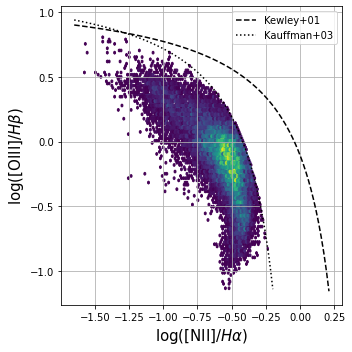

In [15]:
fig, ax = plt.subplots(figsize=(5,5))#,sharex='col',sharey='row')
im = ax.hexbin(Database_SF['NII_Ha'],Database_SF['OIII_Hb'],mincnt=1)
ax.plot(xNII[0],yNII[0],c='k',ls='--',label='Kewley+01')
ax.plot(xNII[1],yNII[1],c='k',ls=':',label='Kauffman+03')
ax.set_xlabel(r'log([NII]/$H\alpha$)',size=15)
ax.set_ylabel(r'log([OIII]/$H\beta$)',size=15)
ax.grid(True)
fig.tight_layout()
ax.legend(loc='best')
plt.show()

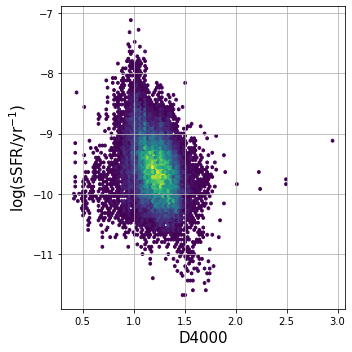

In [38]:
fig, ax = plt.subplots(figsize=(5,5))#,sharex='col',sharey='row')
im = ax.hexbin(Database_SF['D4000'],np.log10(Database_SF['sSFR']),mincnt=1)
ax.set_xlabel(r'D4000',size=15)
ax.set_ylabel(r'log(sSFR/yr$^{-1}$)',size=15)
ax.grid(True)
fig.tight_layout()
#ax.legend(loc='best')
plt.show()

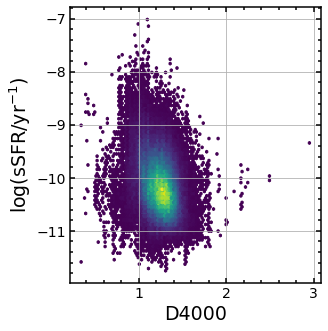

In [48]:
fig, ax = plt.subplots(figsize=(5,5))#,sharex='col',sharey='row')
im = ax.hexbin(Database_SF['D4000'],np.log10(Database_SF['sSFR']),mincnt=1)
ax.set_xlabel(r'D4000')
ax.set_ylabel(r'log(sSFR/yr$^{-1}$)')
ax.grid(True)
fig.tight_layout()
#ax.legend(loc='best')
plt.show()

In [35]:
D4_binwidth = 0.05
concat_byD4 = concat.groupby(create_bins(concat['D4000'],D4_binwidth,init_value=1.0))
concat_byD4_median = concat_byD4.median()#[['log_S_Mstar','log_S_SFR','R_21','Z_O3N2','Z_N2','alphaCO_O3N2','alphaCO_N2','log_S_mol_O3N2','CO_vdisp','star_vdisp','log_f_CO','log_sSFR','log_SFE','log_P_h']].median()

In [36]:
concat_byD4_median['sSFR_D4_lower'] = concat_byD4['sSFR_D4'].apply(lambda x: np.percentile(x,16))
concat_byD4_median['sSFR_D4_upper'] = concat_byD4['sSFR_D4'].apply(lambda x: np.percentile(x,84))
concat_byD4_median['sSFR_D4_uncl'] = concat_byD4_median['sSFR_D4']-concat_byD4_median['sSFR_D4_lower']
concat_byD4_median['sSFR_D4_uncu'] = concat_byD4_median['sSFR_D4_upper']-concat_byD4_median['sSFR_D4']

In [45]:
plt.rcParams['figure.facecolor'] = 'white'
from matplotlib import rc
rc('font',family='DejaVu Sans',size=20)
#rc('font',family='DejaVu',size=20)
rc('mathtext',fontset='dejavusans')
rc('figure', figsize=(1.41421356237*6.,6.)) 
rc('lines', linewidth=1.8,marker=None,markersize=8 )
rc('axes', linewidth=1.5,labelsize=19)#,prop_cycle=plt.cycler(color=('k','r','b','darkorange','steelblue','hotpink','gold','c','maroon','darkgreen')) )
rc(('xtick.major','ytick.major'), size=5.2,width=1.5)
rc(('xtick.minor','ytick.minor'), size=3.2,width=1.5,visible=True)
rc(('xtick','ytick'), labelsize=14, direction='in' )
rc(('xtick'), top=True,bottom=True ) # For some stupid reason you have to do these seperately
rc(('ytick'), left=True,right=True )
rc('legend',numpoints=1,scatterpoints=1,labelspacing=0.2,fontsize=15,fancybox=True,handlelength=1.5,
            handletextpad=0.5)
rc('savefig', dpi=150,format='pdf',bbox='tight' )
rc('errorbar',capsize=3.)

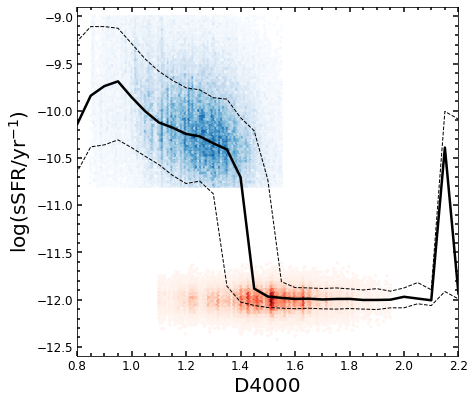

In [49]:
fig, ax = plt.subplots(figsize=(7,6))#,sharex='col',sharey='row')
im = ax.hexbin(Database_SF['D4000'],np.log10(Database_SF['sSFR_D4']),mincnt=1,cmap='Blues',extent=(0.85,1.55,-10.8,-9))
im = ax.hexbin(Database_Q['D4000'],np.log10(Database_Q['sSFR_D4']),mincnt=1,cmap='Reds',extent=(1.1,1.95,-13,-10.8))
#ax.scatter(concat_byD4_median.index.to_numpy(),concat_byD4_median['log_sSFR_D4'].to_numpy(),c='r')
ax.plot(concat_byD4_median.index.to_numpy(),np.log10(concat_byD4_median['sSFR_D4']).to_numpy(),c='k',lw=2.5)
ax.plot(concat_byD4_median.index.to_numpy(),np.log10(concat_byD4_median['sSFR_D4_lower']).to_numpy(),c='k',lw=1,ls='--')
ax.plot(concat_byD4_median.index.to_numpy(),np.log10(concat_byD4_median['sSFR_D4_upper']).to_numpy(),c='k',lw=1,ls='--')
ax.set_xlabel(r'D4000')#,size=15)
ax.set_ylabel(r'log(sSFR/yr$^{-1}$)')#,size=15)
ax.set_xlim(0.8,2.2)
ax.set_ylim(-12.6,-8.9)
#ax.grid(True)
fig.tight_layout()
#ax.legend(loc='best')
plt.show()

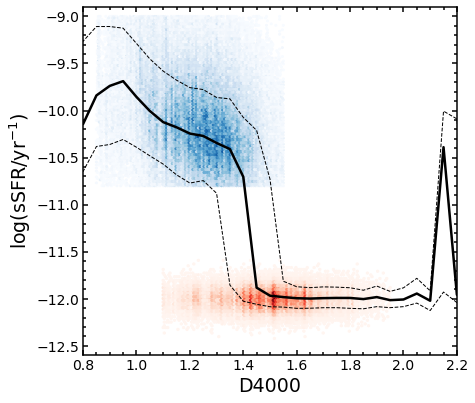

In [32]:
fig, ax = plt.subplots(figsize=(7,6))#,sharex='col',sharey='row')
im = ax.hexbin(Database_SF['D4000'],np.log10(Database_SF['sSFR_D4']),mincnt=1,cmap='Blues',extent=(0.85,1.55,-10.8,-9))
im = ax.hexbin(Database_Q['D4000'],np.log10(Database_Q['sSFR_D4']),mincnt=1,cmap='Reds',extent=(1.1,1.95,-13,-10.8))
#ax.scatter(concat_byD4_median.index.to_numpy(),concat_byD4_median['log_sSFR_D4'].to_numpy(),c='r')
ax.plot(concat_byD4_median.index.to_numpy(),np.log10(concat_byD4_median['sSFR_D4']).to_numpy(),c='k',lw=2.5)
ax.plot(concat_byD4_median.index.to_numpy(),np.log10(concat_byD4_median['sSFR_D4_lower']).to_numpy(),c='k',lw=1,ls='--')
ax.plot(concat_byD4_median.index.to_numpy(),np.log10(concat_byD4_median['sSFR_D4_upper']).to_numpy(),c='k',lw=1,ls='--')
ax.set_xlabel(r'D4000')#,size=15)
ax.set_ylabel(r'log(sSFR/yr$^{-1}$)')#,size=15)
ax.set_xlim(0.8,2.2)
ax.set_ylim(-12.6,-8.9)
#ax.grid(True)
fig.tight_layout()
#ax.legend(loc='best')
plt.show()

In [37]:
concat_byD4_median = concat_byD4_median[(concat_byD4_median.index>0.93)&(concat_byD4_median['D4000']<1.9)]
concat_byD4_median

,D4000,sSFR_D4,sSFR_D4_lower,sSFR_D4_upper,sSFR_D4_uncl,sSFR_D4_uncu
D4000,,,,,,
0.95,0.978470,2.052726e-10,4.930045e-11,7.501569e-10,1.559722e-10,5.448842e-10
1.00,1.027844,1.395570e-10,4.072432e-11,5.159587e-10,9.883267e-11,3.764017e-10
1.05,1.074001,9.900109e-11,3.304975e-11,3.538883e-10,6.595134e-11,2.548872e-10
1.10,1.125969,7.536624e-11,2.698209e-11,2.625535e-10,4.838415e-11,1.871873e-10
1.15,1.177288,6.641483e-11,2.075978e-11,2.102454e-10,4.565505e-11,1.438305e-10
1.20,1.224799,5.694296e-11,1.697117e-11,1.753842e-10,3.997179e-11,1.184412e-10
1.25,1.275396,5.371554e-11,1.802671e-11,1.670772e-10,3.568883e-11,1.133617e-10
1.30,1.324133,4.526449e-11,1.322953e-11,1.376289e-10,3.203496e-11,9.236438e-11
1.35,1.375348,3.895438e-11,1.398724e-12,1.330331e-10,3.755566e-11,9.407874e-11


In [39]:
concat_byD4_median.loc[(concat_byD4_median.index>1.5),'sSFR_D4'] = 10**-12

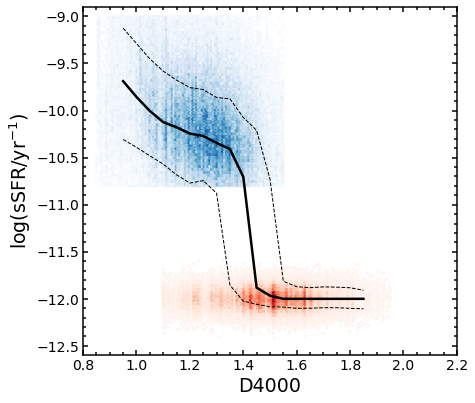

In [40]:
fig, ax = plt.subplots(figsize=(7,6))#,sharex='col',sharey='row')
im = ax.hexbin(Database_SF['D4000'],np.log10(Database_SF['sSFR_D4']),mincnt=1,cmap='Blues',extent=(0.85,1.55,-10.8,-9))
im = ax.hexbin(Database_Q['D4000'],np.log10(Database_Q['sSFR_D4']),mincnt=1,cmap='Reds',extent=(1.1,1.95,-13,-10.8))
#ax.scatter(concat_byD4_median.index.to_numpy(),concat_byD4_median['log_sSFR_D4'].to_numpy(),c='r')
ax.plot(concat_byD4_median.index.to_numpy(),np.log10(concat_byD4_median['sSFR_D4']).to_numpy(),c='k',lw=2.5)
ax.plot(concat_byD4_median.index.to_numpy(),np.log10(concat_byD4_median['sSFR_D4_lower']).to_numpy(),c='k',lw=1,ls='--')
ax.plot(concat_byD4_median.index.to_numpy(),np.log10(concat_byD4_median['sSFR_D4_upper']).to_numpy(),c='k',lw=1,ls='--')
ax.set_xlabel(r'D4000')#,size=15)
ax.set_ylabel(r'log(sSFR/yr$^{-1}$)')#,size=15)
ax.set_xlim(0.8,2.2)
ax.set_ylim(-12.6,-8.9)
#ax.grid(True)
fig.tight_layout()
#ax.legend(loc='best')
plt.show()

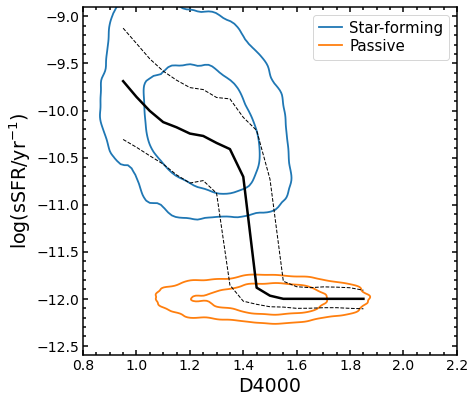

In [46]:
fig, ax = plt.subplots(figsize=(7,6))
ax.plot([1,2],[-14,-143],c='tab:blue',label='Star-forming')
ax.plot([1,2],[-14,-143],c='tab:orange',label='Passive')
ax.legend(loc='upper right')
sns.kdeplot(Database_SF, x="D4000",y="log_sSFR_D4",levels=[.05,.32],ax=ax)
sns.kdeplot(Database_Q, x="D4000",y="log_sSFR_D4",levels=[.05,.32],ax=ax)
ax.plot(concat_byD4_median.index.to_numpy(),np.log10(concat_byD4_median['sSFR_D4']).to_numpy(),c='k',lw=2.5)
ax.plot(concat_byD4_median.index.to_numpy(),np.log10(concat_byD4_median['sSFR_D4_lower']).to_numpy(),c='k',lw=1,ls='--')
ax.plot(concat_byD4_median.index.to_numpy(),np.log10(concat_byD4_median['sSFR_D4_upper']).to_numpy(),c='k',lw=1,ls='--')
ax.set_xlabel(r'D4000')
ax.set_ylabel(r'log(sSFR/yr$^{-1}$)')
ax.set_xlim(0.8,2.2)
ax.set_ylim(-12.6,-8.9)
fig.tight_layout()
fig.savefig(figurepath+'D4-sSFR_relation')
fig.savefig(colloquiumpath+'D4-sSFR_relation.png')
plt.show()

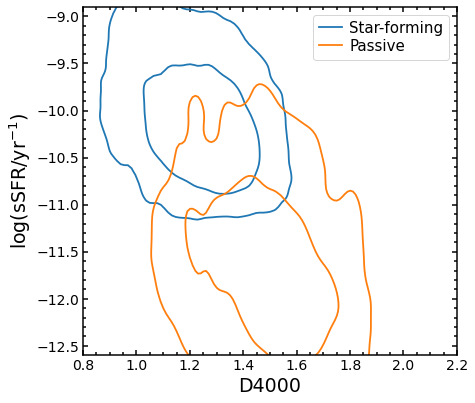

In [47]:
fig, ax = plt.subplots(figsize=(7,6))
ax.plot([1,2],[-14,-143],c='tab:blue',label='Star-forming')
ax.plot([1,2],[-14,-143],c='tab:orange',label='Passive')
ax.legend(loc='upper right')
sns.kdeplot(Database_SF, x="D4000",y="log_sSFR",levels=[.05,.32],ax=ax)
sns.kdeplot(Database_Q, x="D4000",y="log_sSFR",levels=[.05,.32],ax=ax)
#ax.plot(concat_byD4_median.index.to_numpy(),np.log10(concat_byD4_median['sSFR_D4']).to_numpy(),c='k',lw=2.5)
#ax.plot(concat_byD4_median.index.to_numpy(),np.log10(concat_byD4_median['sSFR_D4_lower']).to_numpy(),c='k',lw=1,ls='--')
#ax.plot(concat_byD4_median.index.to_numpy(),np.log10(concat_byD4_median['sSFR_D4_upper']).to_numpy(),c='k',lw=1,ls='--')
ax.set_xlabel(r'D4000')
ax.set_ylabel(r'log(sSFR/yr$^{-1}$)')
ax.set_xlim(0.8,2.2)
ax.set_ylim(-12.6,-8.9)
fig.tight_layout()
fig.savefig(figurepath+'D4-sSFR')
fig.savefig(colloquiumpath+'D4-sSFR.png')
plt.show()

In [52]:
concat_byD4_median.index

Index([              0.95,                1.0,               1.05,
                      1.1,               1.15,                1.2,
                     1.25,                1.3,               1.35,
                      1.4,               1.45,                1.5,
                     1.55,                1.6,               1.65,
       1.7000000000000002,               1.75,                1.8,
                     1.85,                1.9, 1.9500000000000002],
      dtype='float64', name='D4000')

In [53]:
concat_byD4_median.index = np.floor(concat_byD4_median.index*20)/20

In [54]:
concat_byD4_median.index

Index([0.95,  1.0, 1.05,  1.1, 1.15,  1.2, 1.25,  1.3, 1.35,  1.4, 1.45,  1.5,
       1.55,  1.6, 1.65,  1.7, 1.75,  1.8, 1.85,  1.9, 1.95],
      dtype='float64', name='D4000')

In [56]:
concat_byD4_median.to_csv(databasepath+'D4000_sSFR_'+strftime("%Y-%m-%d",localtime())+'.csv')

In [57]:
D4000_min = 0.95#np.min(D4000_sSFR.index)
D4000_max = 1.45#np.max(D4000_sSFR.index)
Database_SF['D4000_binned'] = Database_SF['D4000'].copy()
Database_SF['D4000_binned'] = create_bins(Database_SF['D4000_binned'],D4_binwidth)
Database_SF['D4000_binned'] = np.trunc(Database_SF['D4000_binned']*100)/100
    #D4000_binned = np.where(D4000_binned<D4000_min,D4000_min,D4000_binned)
    #D4000_binned = np.where(D4000_binned>D4000_max,D4000_max,D4000_binned)
Database_SF['D4000_binned'] = np.where(Database_SF['D4000_binned']< D4000_min,np.nan,Database_SF['D4000_binned'])
Database_SF['D4000_binned'] = np.where(Database_SF['D4000_binned']>=D4000_max,np.nan,Database_SF['D4000_binned'])

In [58]:
Database_SF

,Source,Inclination,S_Mstar,S_SFR_Ha,Ha_mask,Ha,eHa,Hb,eHb,OIII,...,eNII,D4000,eD4000,Age,sSFR,log_sSFR,OIII_Hb,NII_Ha,sSFR_D4,D4000_binned
49,CGCG429-012,59.991884,1.285106e+06,0.000078,1,0.006223,0.005388,0.002494,0.008088,0.000167,...,0.004552,1.209873,0.013550,7.943174e+08,6.064348e-11,-10.217216,-1.175335,-0.652883,6.064348e-11,1.20
86,CGCG429-012,59.991884,1.216889e+06,0.000061,1,0.004907,0.004780,0.003829,0.008058,0.000301,...,0.005264,1.209873,0.013550,7.521528e+08,5.050014e-11,-10.296707,-1.103985,-0.726847,5.050014e-11,1.20
115,CGCG429-012,59.991884,1.336433e+06,0.000158,1,0.018278,0.012955,0.017129,0.014916,0.007022,...,0.011336,1.214488,0.006507,8.545298e+08,1.179179e-10,-9.928420,-0.387297,-0.295984,1.179179e-10,1.20
128,CGCG429-012,59.991884,1.640326e+06,0.000110,1,0.008794,0.007649,0.005309,0.011271,0.002378,...,0.006651,1.209873,0.013550,1.013877e+09,6.713729e-11,-10.173036,-0.348773,-0.676836,6.713729e-11,1.20
142,CGCG429-012,59.991884,2.547127e+06,0.000175,1,0.014001,0.012499,0.008689,0.015068,0.004754,...,0.009659,1.191644,0.012057,3.165604e+09,6.883580e-11,-10.162186,-0.261898,-0.010144,6.883580e-11,1.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672646,UGC12348,62.206514,1.662264e+05,0.000201,1,0.009938,0.006392,0.002556,0.019558,0.005956,...,0.009661,0.931253,0.004308,2.686533e+06,1.206430e-09,-8.918498,0.367378,-1.292348,1.206430e-09,NaN
672663,UGC12348,62.206514,1.289286e+05,0.000250,1,0.012387,0.009408,-0.000022,0.010448,-0.000051,...,0.005714,0.942301,0.006373,5.276505e+06,1.938608e-09,-8.712510,0.364675,-1.469611,1.938608e-09,NaN
672679,UGC12348,62.206514,2.484132e+05,0.000456,1,0.022579,0.017979,0.013916,0.018615,0.039604,...,0.010632,0.931253,0.004308,4.014828e+06,1.834053e-09,-8.736588,0.454216,-0.579597,1.834053e-09,NaN
672680,UGC12348,62.206514,4.928657e+05,0.000289,1,0.034866,0.024829,0.036498,0.029205,0.032976,...,0.014433,0.931253,0.004308,7.965643e+06,5.858975e-10,-9.232178,-0.044069,-0.385156,5.858975e-10,NaN


In [59]:
Database_SF['S_SFR_D4_test'] = np.array([concat_byD4_median.loc[element,'sSFR_D4'] if np.isfinite(element) else np.nan for element in Database_SF['D4000_binned']])
Database_SF['S_SFR_D4_test'] = Database_SF['S_SFR_D4_test']*Database_SF['S_Mstar']

In [65]:
mask = np.isfinite(Database_SF['S_SFR_Ha'])&np.isfinite(Database_SF['S_SFR_D4_test'])
SFMS = linregress(np.log10(Database_SF.loc[mask,'S_SFR_Ha']),np.log10(Database_SF.loc[mask,'S_SFR_D4_test']))

-1.1717408789088364
0.6061716909817265


In [68]:
print(SFMS.intercept)
print(SFMS.slope)
print(SFMS.rvalue)

-1.1717408789088364
0.6061716909817265
0.7253739364774271


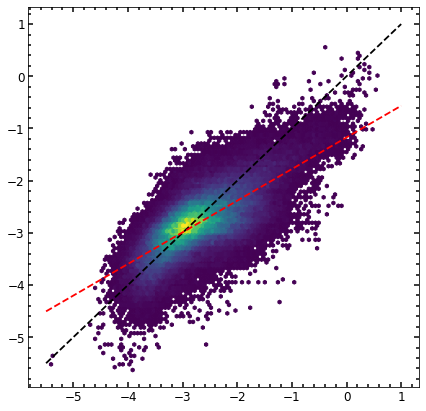

In [70]:
fig, ax = plt.subplots(figsize=(7,7))
ax.hexbin(np.log10(Database_SF['S_SFR_Ha']),np.log10(Database_SF['S_SFR_D4_test']),mincnt=1)
ax.plot([-5.5,1],[-5.5,1],ls='--',c='k')
ax.plot([-5.5,1],[-5.5*SFMS.slope+SFMS.intercept,1*SFMS.slope+SFMS.intercept],ls='--',c='r')
plt.show()

In [42]:
D4_binwidth = 0.05
SF_byD4 = Database_SF[['D4000','sSFR_D4']].groupby(create_bins(Database_SF['D4000'],D4_binwidth,init_value=1.0))
SF_byD4_median = SF_byD4.median()#[['log_S_Mstar','log_S_SFR','R_21','Z_O3N2','Z_N2','alphaCO_O3N2','alphaCO_N2','log_S_mol_O3N2','CO_vdisp','star_vdisp','log_f_CO','log_sSFR','log_SFE','log_P_h']].median()

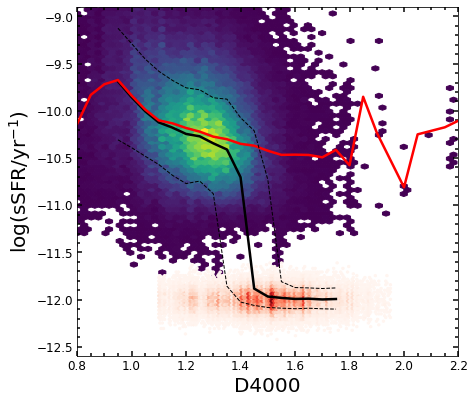

In [45]:
fig, ax = plt.subplots(figsize=(7,6))#,sharex='col',sharey='row')
im = ax.hexbin(Database_SF['D4000'],np.log10(Database_SF['sSFR_D4']),mincnt=1)
im = ax.hexbin(Database_Q['D4000'],np.log10(Database_Q['sSFR_D4']),mincnt=1,cmap='Reds',extent=(1.1,1.95,-13,-10.8))
#ax.scatter(concat_byD4_median.index.to_numpy(),concat_byD4_median['log_sSFR_D4'].to_numpy(),c='r')
ax.plot(concat_byD4_median.index.to_numpy(),np.log10(concat_byD4_median['sSFR_D4']).to_numpy(),c='k',lw=2.5)
ax.plot(SF_byD4_median.index.to_numpy(),np.log10(SF_byD4_median['sSFR_D4']).to_numpy(),c='r',lw=2.5)
ax.plot(concat_byD4_median.index.to_numpy(),np.log10(concat_byD4_median['sSFR_D4_lower']).to_numpy(),c='k',lw=1,ls='--')
ax.plot(concat_byD4_median.index.to_numpy(),np.log10(concat_byD4_median['sSFR_D4_upper']).to_numpy(),c='k',lw=1,ls='--')
ax.set_xlabel(r'D4000')#,size=15)
ax.set_ylabel(r'log(sSFR/yr$^{-1}$)')#,size=15)
ax.set_xlim(0.8,2.2)
ax.set_ylim(-12.6,-8.9)
#ax.grid(True)
fig.tight_layout()
#ax.legend(loc='best')
plt.show()

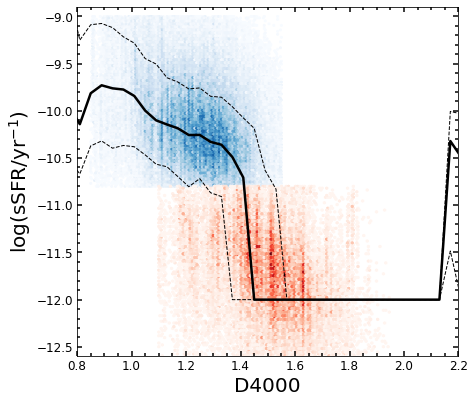

In [217]:
fig, ax = plt.subplots(figsize=(7,6))#,sharex='col',sharey='row')
im = ax.hexbin(Database_SF['D4000'],np.log10(Database_SF['sSFR_D4']),mincnt=1,cmap='Blues',extent=(0.85,1.55,-10.8,-9))
im = ax.hexbin(Database_Q['D4000'],np.log10(Database_Q['sSFR']),mincnt=1,cmap='Reds',extent=(1.1,1.95,-13,-10.8))
#ax.scatter(concat_byD4_median.index.to_numpy(),concat_byD4_median['log_sSFR_D4'].to_numpy(),c='r')
ax.plot(concat_byD4_median.index.to_numpy(),np.log10(concat_byD4_median['sSFR_D4']).to_numpy(),c='k',lw=2.5)
ax.plot(concat_byD4_median.index.to_numpy(),np.log10(concat_byD4_median['sSFR_D4_lower']).to_numpy(),c='k',lw=1,ls='--')
ax.plot(concat_byD4_median.index.to_numpy(),np.log10(concat_byD4_median['sSFR_D4_upper']).to_numpy(),c='k',lw=1,ls='--')
ax.set_xlabel(r'D4000')#,size=15)
ax.set_ylabel(r'log(sSFR/yr$^{-1}$)')#,size=15)
ax.set_xlim(0.8,2.2)
ax.set_ylim(-12.6,-8.9)
#ax.grid(True)
fig.tight_layout()
#ax.legend(loc='best')
plt.show()

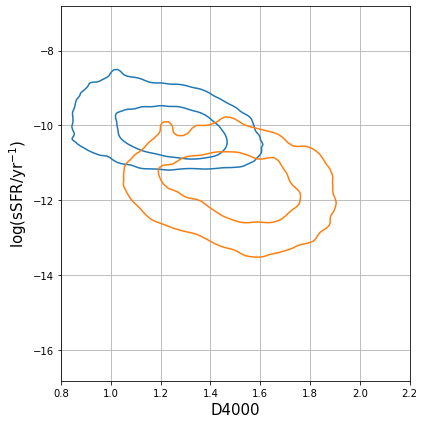

In [113]:
fig, ax = plt.subplots(figsize=(6,6))#,sharex='col',sharey='row')
#im = ax.hexbin(concat['D4000'],np.log10(concat['sSFR_new']),mincnt=1,cmap='Blues')
#im = ax.hexbin(Database_SF['D4000'],np.log10(Database_SF['sSFR_new']),mincnt=1,cmap='Blues')
#im = ax.hexbin(Database_Q['D4000'],np.log10(Database_Q['sSFR']),mincnt=1,cmap='Reds')
sns.kdeplot(Database_SF, x="D4000", y="log_sSFR",levels=[.05,.32],ax=ax)
sns.kdeplot(Database_Q,  x="D4000", y="log_sSFR",levels=[.05,.32],ax=ax)
#ax.plot(concat_byD4_median['D4000'].to_numpy(),np.log10(concat_byD4_median['sSFR_new'].to_numpy()),c='k')
ax.set_xlabel(r'D4000',size=15)
ax.set_ylabel(r'log(sSFR/yr$^{-1}$)',size=15)
ax.set_xlim(0.8,2.2)
ax.grid(True)
fig.tight_layout()
#ax.legend(loc='best')
plt.show()

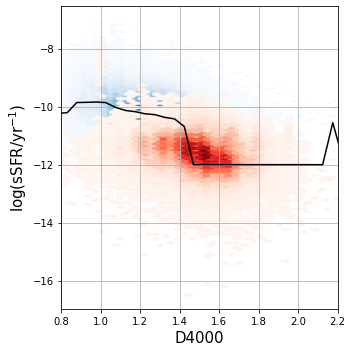

In [42]:
fig, ax = plt.subplots(figsize=(5,5))#,sharex='col',sharey='row')
#im = ax.hexbin(concat['D4000'],np.log10(concat['sSFR_new']),mincnt=1,cmap='Blues')
im = ax.hexbin(Database_SF['D4000'],np.log10(Database_SF['sSFR_new']),mincnt=1,cmap='Blues')
im = ax.hexbin(Database_Q['D4000'],np.log10(Database_Q['sSFR']),mincnt=1,cmap='Reds')
ax.plot(concat_byD4_median['D4000'].to_numpy(),np.log10(concat_byD4_median['sSFR_new'].to_numpy()),c='k')
ax.set_xlabel(r'D4000',size=15)
ax.set_ylabel(r'log(sSFR/yr$^{-1}$)',size=15)
ax.set_xlim(0.8,2.2)
ax.grid(True)
fig.tight_layout()
#ax.legend(loc='best')
plt.show()

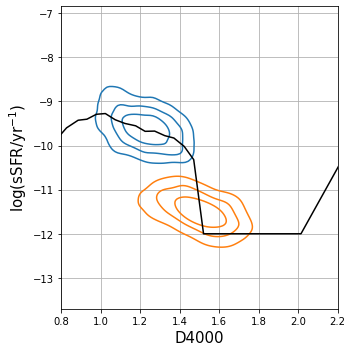

In [112]:
fig, ax = plt.subplots(figsize=(5,5))#,sharex='col',sharey='row')
#im = ax.hexbin(concat['D4000'],np.log10(concat['sSFR_new']),mincnt=1,cmap='Blues')
#im = ax.hexbin(Database_SF['D4000'],np.log10(Database_SF['sSFR_new']),mincnt=1,cmap='Blues')
#im = ax.hexbin(Database_Q['D4000'],np.log10(Database_Q['sSFR']),mincnt=1,cmap='Reds')
sns.kdeplot(Database_SF, x="D4000", y="log_sSFR",levels=[.25,.5,.75],ax=ax)
sns.kdeplot(Database_Q,  x="D4000", y="log_sSFR",levels=[.25,.5,.75],ax=ax)
ax.plot(concat_byD4_median['D4000'].to_numpy(),np.log10(concat_byD4_median['sSFR_new'].to_numpy()),c='k')
ax.set_xlabel(r'D4000',size=15)
ax.set_ylabel(r'log(sSFR/yr$^{-1}$)',size=15)
ax.set_xlim(0.8,2.2)
ax.grid(True)
fig.tight_layout()
#ax.legend(loc='best')
plt.show()

In [17]:
SFMS = linregress(np.log10(Database_SF['S_Mstar']),np.log10(Database_SF['S_SFR_Ha']))
print(SFMS.intercept)
print(SFMS.slope)

-7.390887268369459
0.6888280389733579


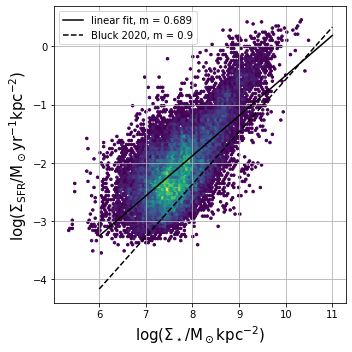

In [27]:
fig, ax = plt.subplots(figsize=(5,5))#,sharex='col',sharey='row')
im = ax.hexbin(np.log10(Database_SF['S_Mstar']),np.log10(Database_SF['S_SFR_Ha']),mincnt=1)
ax.plot([6,11],[6*SFMS.slope+SFMS.intercept,11*SFMS.slope+SFMS.intercept],c='k',label=f'linear fit, m = {SFMS.slope:.3}')
ax.plot([6,11],[6*0.9-9.57,11*0.9-9.57],c='k',ls='--',label='Bluck 2020, m = 0.9')
ax.set_xlabel(r'log($\Sigma_\star$/M$_\odot$kpc$^{-2}$)',size=15)
ax.set_ylabel(r'log($\Sigma_\mathrm{SFR}$/M$_\odot$yr$^{-1}$kpc$^{-2}$)',size=15)
ax.grid(True)
fig.tight_layout()
ax.legend(loc='best')
plt.show()

In [19]:
Database_SF['logS_Mstar'] = np.log10(Database_SF['S_Mstar'])
Database_SF['logS_SFR_Ha'] = np.log10(Database_SF['S_SFR_Ha'])

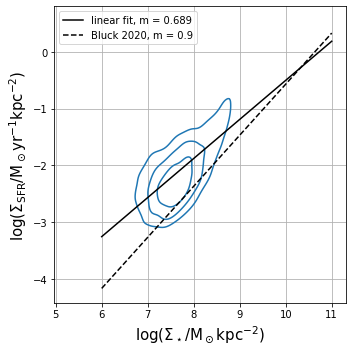

In [25]:
fig, ax = plt.subplots(figsize=(5,5))#,sharex='col',sharey='row')
#im = ax.hexbin(np.log10(Database_SF['S_Mstar']),np.log10(Database_SF['S_SFR_Ha']),mincnt=1)
sns.kdeplot(Database_SF, x="logS_Mstar", y="logS_SFR_Ha",levels=[.25,.5,.75],ax=ax)
ax.plot([6,11],[6*SFMS.slope+SFMS.intercept,11*SFMS.slope+SFMS.intercept],c='k',label=f'linear fit, m = {SFMS.slope:.3}')
ax.plot([6,11],[6*0.9-9.57,11*0.9-9.57],c='k',ls='--',label='Bluck 2020, m = 0.9')
ax.set_xlabel(r'log($\Sigma_\star$/M$_\odot$kpc$^{-2}$)',size=15)
ax.set_ylabel(r'log($\Sigma_\mathrm{SFR}$/M$_\odot$yr$^{-1}$kpc$^{-2}$)',size=15)
ax.grid(True)
fig.tight_layout()
ax.legend(loc='best')
plt.show()

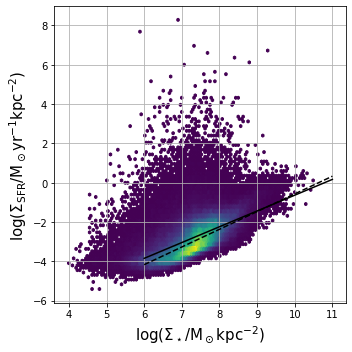

In [10]:
fig, ax = plt.subplots(figsize=(5,5))#,sharex='col',sharey='row')
pearson = linregress(np.log10(Database.loc[Database['Ha_mask']==1,'S_Mstar']),np.log10(Database.loc[Database['Ha_mask']==1,'S_SFR_Ha']))
im = ax.hexbin(np.log10(Database.loc[Database['Ha_mask']==1,'S_Mstar']),np.log10(Database.loc[Database['Ha_mask']==1,'S_SFR_Ha']),mincnt=1)
ax.plot([6,11],[6*pearson.slope+pearson.intercept,11*pearson.slope+pearson.intercept],c='k')
ax.plot([6,11],[6*0.9-9.57,11*0.9-9.57],c='k',ls='--')
ax.set_xlabel(r'log($\Sigma_\star$/M$_\odot$kpc$^{-2}$)',size=15)
ax.set_ylabel(r'log($\Sigma_\mathrm{SFR}$/M$_\odot$yr$^{-1}$kpc$^{-2}$)',size=15)
ax.grid(True)
fig.tight_layout()
#ax.legend(loc='best')
plt.show()